In [1]:
# Author: Swapnil Acharya
# Date: 6/28/2021

# Comparision of Deep Learning Algorithms based on Transfer Learning

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
print(tf.__version__)

2.5.0


## Prepare Dataset

In [4]:
# {"username":"hellosomeone","key":"2972477b7742f4e1003abb2dac2d52ca"}

In [5]:
# https://www.kaggle.com/andrewmvd/medical-mnist

In [6]:
import os

os.environ['KAGGLE_USERNAME'] = "hellosomeone" # username from the json file
os.environ['KAGGLE_KEY'] = "2972477b7742f4e1003abb2dac2d52ca" # key from the json file

In [7]:
!kaggle datasets download -d andrewmvd/medical-mnist

medical-mnist.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
!ls

Accuracy_Comparision.jpg  medical_mnist      sample_data
Loss_Comparision.jpg	  medical-mnist.zip


In [9]:
mkdir medical_mnist

mkdir: cannot create directory ‘medical_mnist’: File exists


In [10]:
!ls

Accuracy_Comparision.jpg  medical_mnist      sample_data
Loss_Comparision.jpg	  medical-mnist.zip


In [11]:
!unzip -q medical-mnist.zip -d medical_mnist/

replace medical_mnist/AbdomenCT/000000.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace medical_mnist/AbdomenCT/000001.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
y


In [12]:
!ls

Accuracy_Comparision.jpg  medical_mnist      sample_data
Loss_Comparision.jpg	  medical-mnist.zip


In [13]:
!ls medical_mnist

AbdomenCT  BreastMRI  ChestCT  CXR  Hand  HeadCT


## Create Train and Valid dataset

In [14]:
data_dir = "medical_mnist/"

BATCH_SIZE = 32
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_SHAPE = (IMAGE_HEIGHT,IMAGE_WIDTH,3)

In [15]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir,
                                                              labels="inferred",
                                                              label_mode="int",
                                                              batch_size=BATCH_SIZE,
                                                              image_size=(IMAGE_HEIGHT,IMAGE_WIDTH),
                                                              shuffle=True,
                                                              seed=1,
                                                              validation_split=0.2,
                                                              subset="training")

Found 58954 files belonging to 6 classes.
Using 47164 files for training.


In [16]:
class_names = train_ds.class_names
class_names

['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']

In [17]:
print(f"Num batches in Training Set: {len(train_ds)}")

Num batches in Training Set: 1474


In [18]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(directory=data_dir,
                                                              labels = "inferred",
                                                              label_mode = "int",
                                                              batch_size = BATCH_SIZE,
                                                              image_size = (IMAGE_HEIGHT,IMAGE_WIDTH),
                                                              shuffle = True,
                                                              seed = 1,
                                                              validation_split = 0.2,
                                                              subset="validation")

Found 58954 files belonging to 6 classes.
Using 11790 files for validation.


## Visualize Data

In [19]:
#get a batch of data from training set
image_batch, label_batch = next(iter(train_ds))

[]

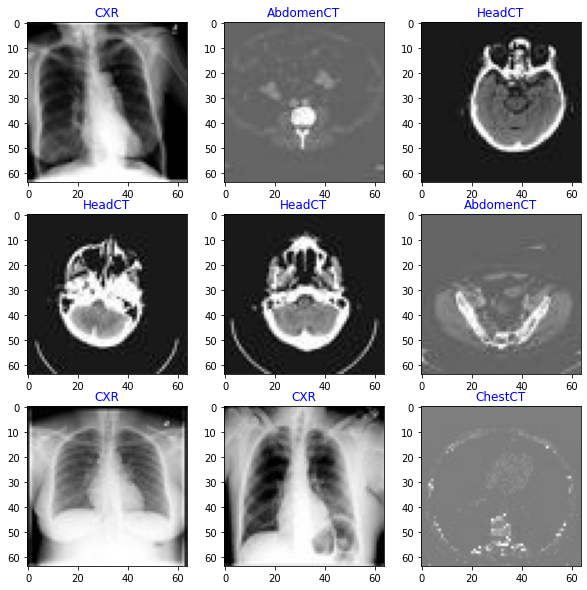

In [20]:
fig, ax = plt.subplots(3,3,figsize=(10,10))

for index, a in enumerate(fig.axes):
    a.imshow(np.array(image_batch[index],np.uint8))
    a.title.set_text(class_names[label_batch[index]])
    a.title.set_color("blue")
plt.plot()

## Create Test Set

So far only Training Set and VLidation Set have been created, a test set can be created by taking a batch from validation set.
It is important to make sure that validation and test set are from the same ditribution.

In [21]:
#get a set of batchs

val_batches = tf.data.experimental.cardinality(valid_ds)
val_batches

<tf.Tensor: shape=(), dtype=int64, numpy=369>

In [22]:
#get 20% of data from validation set to train set
test_ds = valid_ds.take(val_batches// 5)

In [23]:
#set the remaing 80% as validaion set
valid_ds = valid_ds.skip(val_batches//5)

In [24]:
print(f"Number of Validation Batches: {len(valid_ds)}")

Number of Validation Batches: 296


In [25]:
print(f"Number of Testing Batches: {len(test_ds)}")

Number of Testing Batches: 73


## Configure dataset for Performance

In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

In [27]:
# vgg 19
# Inception -v3
# Resnet 50
# inceptipn resent v2
# mobilenet v2
# efficient 

## VGG - 19

### Download Base Model

In [28]:
### Download Base Model
base_model_vgg19 = tf.keras.applications.vgg19.VGG19(include_top=False,
                                                     weights="imagenet",
                                                     input_shape=None)

<p><h4> From Tensorflow website VGG 19 expexts certain kind of inputs. Its own preprocess input must be used whihc will convert the input images from RGB to BGR, them zero-center each color channel with respect to the imageNet dataset, without scaling. In our case, since images are greyscale it probably wont  matter much</h4> </p>

### Get Model's Preprocessing Function

In [29]:
vgg19_preprocess = tf.keras.applications.vgg19.preprocess_input

### Visualize Outputs of Model's Preprocessing Function

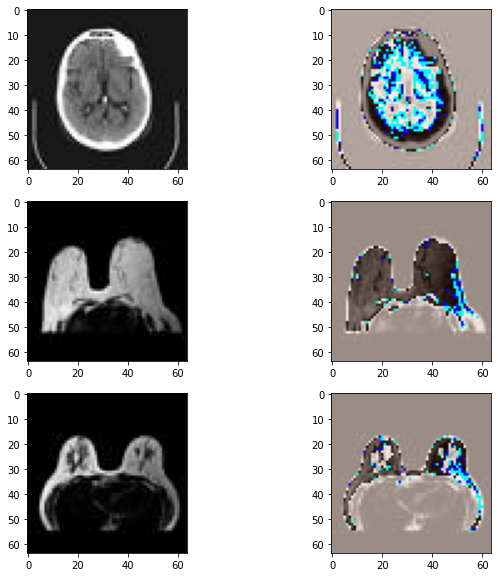

In [30]:
### visuaize the preprocessed input
image_batch, label_batch = next(iter(train_ds))
preprocessed_image_batch = vgg19_preprocess(image_batch)

fig, ax = plt.subplots(3,2,figsize=(10,10))

ax[0,0].imshow(np.array(image_batch[0],dtype=np.uint8))
ax[0,1].imshow(np.array(preprocessed_image_batch[0],dtype=np.uint8))

ax[1,0].imshow(np.array(image_batch[1],dtype=np.uint8))
ax[1,1].imshow(np.array(preprocessed_image_batch[1],dtype=np.uint8))

ax[2,0].imshow(np.array(image_batch[2],dtype=np.uint8))
ax[2,1].imshow(np.array(preprocessed_image_batch[2],dtype=np.uint8))

plt.show()



###Freeze Model For Transfer Learning

In [31]:
# In order to use base model as feature extractor, it must be frezzzed and a classifer layer must be added
base_model_vgg19.trainable = False

In [32]:
base_model_vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

As shown by the outputs of vgg19 summary, clearly the model has been frezzed since the number of trainabel params is 0.

### See output shape of base layer

In [33]:
#lets see the output shape of base layer
inputs = tf.keras.Input(shape=(IMAGE_SHAPE))
x = vgg19_preprocess(inputs)
outputs = base_model_vgg19(x)
model = tf.keras.Model(inputs,outputs)

In [34]:
image_batch,labels = next(iter(train_ds))
predictions = model(image_batch)

In [35]:
predictions.shape

TensorShape([32, 2, 2, 512])

So, the output shape of the base model is shown above, so to generate predictions from block of features over 2x2 spatial locations a global  pooling layer must be used in order to convert it to a single vector. 

### Create Transfer Learning Model

In [36]:
#create model using functional api
inputs = tf.keras.Input(shape=(IMAGE_SHAPE)) #must use tf.keras.Input for Functional
x = vgg19_preprocess(inputs)
x = base_model_vgg19(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(len(class_names),activation='softmax')(x)
model_vgg19 = tf.keras.Model(inputs,outputs)

In [37]:
#compile model
base_learning_rate = 0.0001
model_vgg19.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
             loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics=['accuracy'])

In [38]:
#view model summary
model_vgg19.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
tf.__operators__.getitem_1 ( (None, 64, 64, 3)         0         
_________________________________________________________________
tf.nn.bias_add_1 (TFOpLambda (None, 64, 64, 3)         0         
_________________________________________________________________
vgg19 (Functional)           (None, None, None, 512)   20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 6)                 3078      
Total params: 20,027,462
Trainable params: 3,078
Non-trainable params: 20,024,384
___________________________________________

In [39]:
#initial accuracy
loss0_vgg19, accuracy0_vgg19 = model_vgg19.evaluate(valid_ds)

296/296 [==============================] - 7s 19ms/step - loss: 17.8175 - accuracy: 0.0776


In [40]:
print(f"Initial Loss of Vgg19: {loss0_vgg19}")
print(f"Initial Accuracy of Vgg19: {accuracy0_vgg19}")

Initial Loss of Vgg19: 17.817468643188477
Initial Accuracy of Vgg19: 0.07763909548521042


### Train Model

In [41]:
#train model now
initial_epochs = 5
history_vgg19 = model_vgg19.fit(train_ds,
                         epochs=initial_epochs,
                         validation_data = valid_ds)

Epoch 1/5
1474/1474 [==============================] - 33s 22ms/step - loss: 1.7926 - accuracy: 0.7962 - val_loss: 0.1009 - val_accuracy: 0.9699
Epoch 2/5
1474/1474 [==============================] - 32s 21ms/step - loss: 0.0576 - accuracy: 0.9837 - val_loss: 0.0300 - val_accuracy: 0.9921
Epoch 3/5
1474/1474 [==============================] - 33s 22ms/step - loss: 0.0214 - accuracy: 0.9946 - val_loss: 0.0146 - val_accuracy: 0.9963
Epoch 4/5
1474/1474 [==============================] - 33s 23ms/step - loss: 0.0103 - accuracy: 0.9976 - val_loss: 0.0089 - val_accuracy: 0.9977
Epoch 5/5
1474/1474 [==============================] - 33s 23ms/step - loss: 0.0056 - accuracy: 0.9987 - val_loss: 0.0058 - val_accuracy: 0.9983


### Plot Learning Curves

In [42]:
train_acc = history_vgg19.history['accuracy']
train_loss = history_vgg19.history['loss']

valid_acc = history_vgg19.history['val_accuracy']
valid_loss = history_vgg19.history['val_loss']

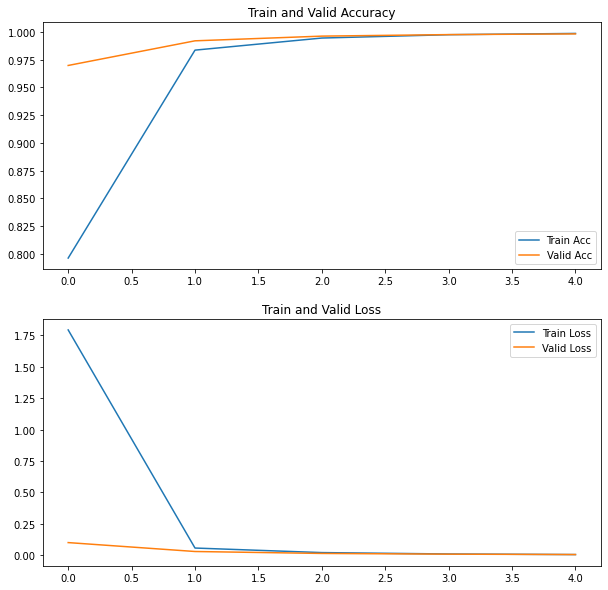

In [43]:

fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(train_acc,label="Train Acc")
ax[0].plot(valid_acc,label="Valid Acc")
ax[0].title.set_text("Train and Valid Accuracy")
ax[0].legend(loc="best")

ax[1].plot(train_loss,label="Train Loss")
ax[1].plot(valid_loss,label="Valid Loss")
ax[1].title.set_text("Train and Valid Loss")
ax[1].legend(loc="best")

plt.show()

### Evaluate on Test Set

In [44]:
# Evaluate on Test Set
acc_vgg19, loss_vgg19 = model_vgg19.evaluate(test_ds)

73/73 [==============================] - 1s 19ms/step - loss: 0.0095 - accuracy: 0.9979


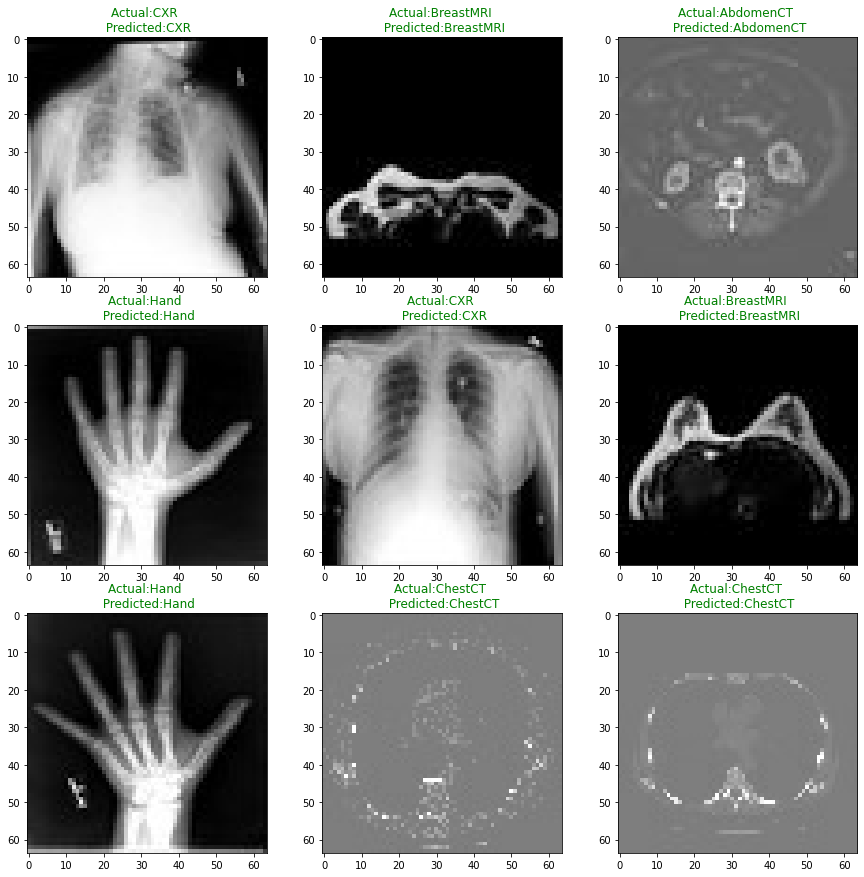

In [45]:
##Visualize some predictions

image_batch, label_batch = next(iter(test_ds))
predictions = model_vgg19.predict(image_batch) #predict on the recently fetched batch from test set
predictions = np.argmax(predictions,axis=1) #get index of highest probability

fig, ax = plt.subplots(3,3,figsize=(15,15))

for index, a in enumerate(fig.axes):

  a.imshow(np.array(image_batch[index],dtype=np.uint8))
  a.title.set_text(f"Actual:{class_names[label_batch[index]]} \n Predicted:{class_names[predictions[index]]}")
  if predictions[index] == label_batch[index]:
    a.title.set_color("green")
  else:
    a.title.set_color("red")

plt.show()

## Resent50-V2

### Download Base Model

In [46]:
base_model_resenet50_v2 = tf.keras.applications.resnet_v2.ResNet50V2(include_top=False,
                                                                  weights="imagenet",
                                                                  input_shape=None)

### Get Model's Preprocessing Function

In [47]:
resetnet50_v2_preprocessing = tf.keras.applications.resnet_v2.preprocess_input

### Visualize Outputs of Model's Preprocessing Function

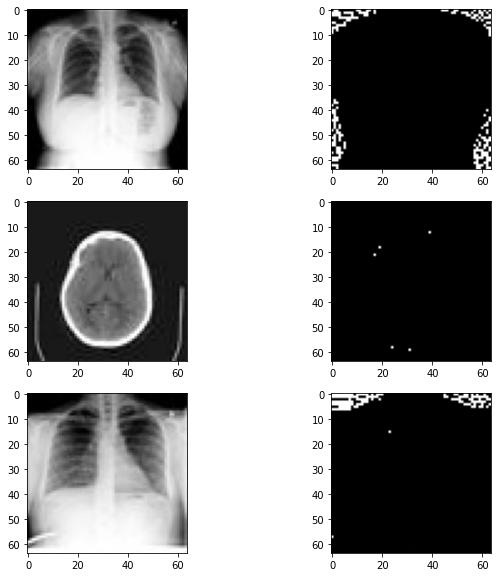

In [48]:
image_batch, label_batch = next(iter(train_ds))
preprocessed_image_batch = resetnet50_v2_preprocessing(image_batch)

fig, ax = plt.subplots(3,2,figsize=(10,10))

ax[0,0].imshow(np.array(image_batch[0],dtype=np.uint8))
ax[0,1].imshow(np.array(preprocessed_image_batch[0],dtype=np.uint8))

ax[1,0].imshow(np.array(image_batch[1],dtype=np.uint8))
ax[1,1].imshow(np.array(preprocessed_image_batch[1],dtype=np.uint8))

ax[2,0].imshow(np.array(image_batch[2],dtype=np.uint8))
ax[2,1].imshow(np.array(preprocessed_image_batch[2],dtype=np.uint8))

plt.show()



### Freeze Model For Transfer Learning

In [49]:
base_model_resenet50_v2.trainable = False

In [50]:
base_model_resenet50_v2.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, None, None, 6 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

### See output shape of base layer

In [51]:
inputs = tf.keras.Input(shape=(IMAGE_SHAPE))
x = resetnet50_v2_preprocessing(inputs)
ouputs = base_model_resenet50_v2(x)
model = tf.keras.Model(inputs,ouputs)

In [52]:
predictions = model(image_batch)

In [53]:
predictions.shape

TensorShape([32, 2, 2, 2048])

### Create Transfer Learning Model

In [54]:
#create model using functional api

inputs = tf.keras.Input(shape=(IMAGE_SHAPE))
x = resetnet50_v2_preprocessing(inputs)
x = base_model_resenet50_v2(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(units = len(class_names),activation='softmax')(x)
model_resnet50v2 = tf.keras.Model(inputs,outputs)

In [55]:
#compile model
base_learning_rate = 0.0001
model_resnet50v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                         loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                         metrics=['accuracy'])

In [56]:
#view model summary

model_resnet50v2.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 64, 64, 3)         0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 64, 64, 3)         0         
_________________________________________________________________
resnet50v2 (Functional)      (None, None, None, 2048)  23564800  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 12294     
Total params: 23,577,094
Trainable params: 12,294
Non-trainable params: 23,564,800
__________________________________________

In [57]:
#initial loss and accuracy
accuracy0_resnet50v2, loss0_resnet50v2 = model_resnet50v2.evaluate(valid_ds)

296/296 [==============================] - 10s 25ms/step - loss: 4.3413 - accuracy: 0.1002


In [58]:
#display the results
print(f"Initial Accuracy of Resent50v2: {accuracy0_resnet50v2}")
print(f"Initial Loss of Resent50v2: {loss0_resnet50v2}")

Initial Accuracy of Resent50v2: 4.341296195983887
Initial Loss of Resent50v2: 0.10016924142837524


### Train Model

In [59]:
initial_epochs = 5
history_resnet50v2 = model_resnet50v2.fit(train_ds,
                                         epochs=initial_epochs,
                                         validation_data = valid_ds)

Epoch 1/5
1474/1474 [==============================] - 44s 28ms/step - loss: 0.2179 - accuracy: 0.9394 - val_loss: 0.0296 - val_accuracy: 0.9951
Epoch 2/5
1474/1474 [==============================] - 42s 29ms/step - loss: 0.0180 - accuracy: 0.9972 - val_loss: 0.0131 - val_accuracy: 0.9974
Epoch 3/5
1474/1474 [==============================] - 41s 28ms/step - loss: 0.0085 - accuracy: 0.9988 - val_loss: 0.0077 - val_accuracy: 0.9986
Epoch 4/5
1474/1474 [==============================] - 41s 28ms/step - loss: 0.0048 - accuracy: 0.9994 - val_loss: 0.0050 - val_accuracy: 0.9989
Epoch 5/5
1474/1474 [==============================] - 41s 28ms/step - loss: 0.0030 - accuracy: 0.9996 - val_loss: 0.0035 - val_accuracy: 0.9993


### Plot Learning Curves

In [60]:
#get training accuracy and loss from history
train_acc = history_resnet50v2.history['accuracy']
train_loss = history_resnet50v2.history['loss']

#get validation accuracy and loss from history
valid_acc = history_resnet50v2.history['val_accuracy']
valid_loss = history_resnet50v2.history['val_loss']

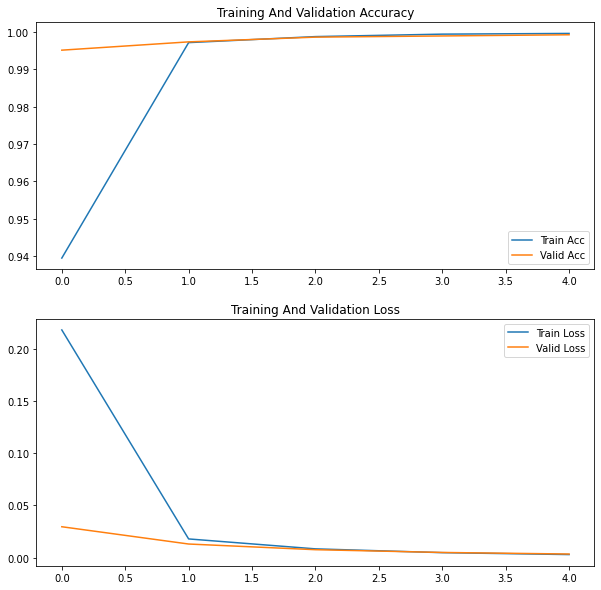

In [61]:
#plot
fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].plot(train_acc,label="Train Acc")
ax[0].plot(valid_acc,label="Valid Acc")
ax[0].title.set_text("Training And Validation Accuracy")
ax[0].legend(loc='best')

ax[1].plot(train_loss,label="Train Loss")
ax[1].plot(valid_loss,label="Valid Loss")
ax[1].title.set_text("Training And Validation Loss")
ax[1].legend(loc='best')

plt.show()

### Evaluate on Test Set

In [62]:
#evaluate test set
acc_resnet50v2, loss_resnet50v2 = model_resnet50v2.evaluate(test_ds)

73/73 [==============================] - 2s 24ms/step - loss: 0.0026 - accuracy: 0.9996


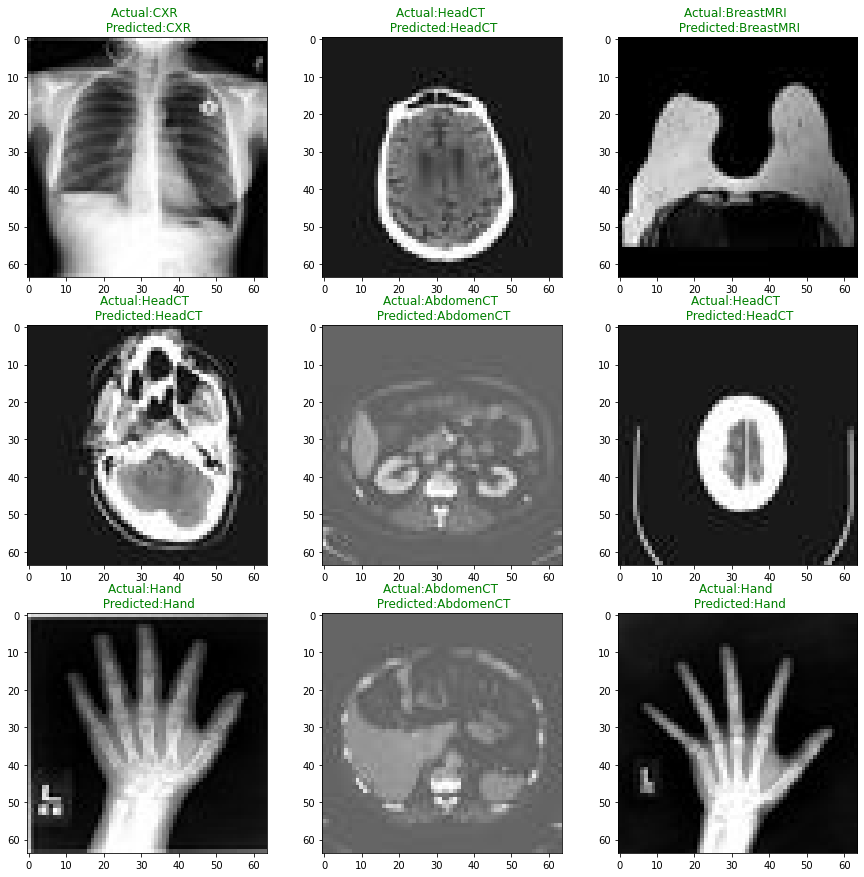

In [63]:
#visualize some results
image_batch, label_batch = next(iter(test_ds))
predictions = model_resnet50v2.predict(image_batch)
predictions = np.argmax(predictions,axis=1)

fig, ax = plt.subplots(3,3,figsize=(15,15))

for index, a in enumerate(fig.axes):
  a.imshow(np.array(image_batch[index],dtype=np.uint8))
  a.title.set_text(f"Actual:{class_names[label_batch[index]]} \n Predicted:{class_names[predictions[index]]}")
  if predictions[index] == label_batch[index]:
    a.title.set_color("green")
  else:
    a.title.set_color("red")

plt.show()

## Xception

### Download Base Model

In [64]:
base_model_xception = tf.keras.applications.xception.Xception(include_top=False,
                                                              weights="imagenet",
                                                              input_shape=None)

### Get Model's Preprocessing Function

In [65]:
xception_preprocessing = tf.keras.applications.xception.preprocess_input

Xception model expects input shape to be at least 71, However the images used here are 64x64. A resizing layer should be used.


In [66]:
inputs = tf.keras.Input(shape=(IMAGE_SHAPE))
x = tf.keras.layers.experimental.preprocessing.Resizing(height=75,width=75) (inputs)
outputs = xception_preprocessing(x)

xception_preprocessing = tf.keras.Model(inputs,outputs)

### Visualize outputs of Model's Preprocessing Function

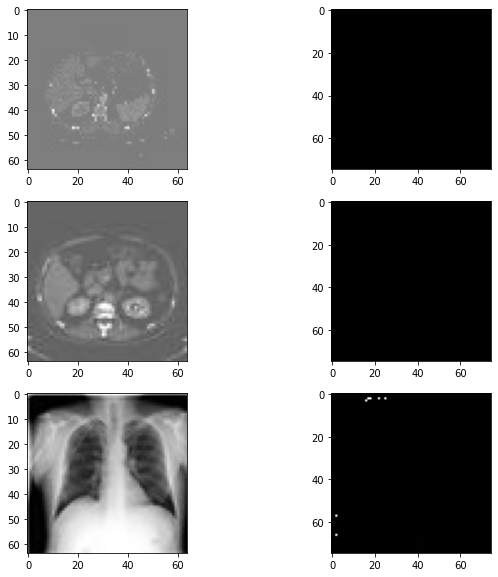

In [67]:
image_batch, label_batch = next(iter(train_ds))
preprocessed_image_batch = xception_preprocessing(image_batch)

fig, ax = plt.subplots(3,2,figsize=(10,10))

ax[0,0].imshow(np.array(image_batch[0],dtype=np.uint8))
ax[0,1].imshow(np.array(preprocessed_image_batch[0],dtype=np.uint8))

ax[1,0].imshow(np.array(image_batch[1],dtype=np.uint8))
ax[1,1].imshow(np.array(preprocessed_image_batch[1],dtype=np.uint8))

ax[2,0].imshow(np.array(image_batch[2],dtype=np.uint8))
ax[2,1].imshow(np.array(preprocessed_image_batch[2],dtype=np.uint8))

plt.show()



### Freeze model for transfer learning

In [68]:
base_model_xception.trainable = False

In [69]:
base_model_xception.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

### See output shape of base layer

In [70]:
inputs = tf.keras.Input(shape=(IMAGE_SHAPE))
x = xception_preprocessing(inputs)
outputs = base_model_xception(x)

model_xception = tf.keras.Model(inputs,outputs)

In [71]:
predictions = model_xception(image_batch)

In [72]:
predictions.shape

TensorShape([32, 3, 3, 2048])

THe output of base xception model sees to be 3x3x2048. To generate predictions out of 3x3 spatial features. A global pooling layer must be used.

### Create Transfer Learning Model

In [73]:
inputs = tf.keras.Input(shape=(IMAGE_SHAPE))
x = xception_preprocessing(inputs)
x = base_model_xception(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(units=len(class_names),activation='softmax')(x)
model_xception = tf.keras.Model(inputs,outputs)

In [74]:
base_learning_rate = 0.0001
model_xception.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                       metrics=['accuracy'])

In [75]:
model_xception.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
model_4 (Functional)         (None, 75, 75, 3)         0         
_________________________________________________________________
xception (Functional)        (None, None, None, 2048)  20861480  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 12294     
Total params: 20,873,774
Trainable params: 12,294
Non-trainable params: 20,861,480
_________________________________________________________________


In [76]:
#evaluate models initial performance
acc0_xception, loss0_xception = model_xception.evaluate(valid_ds)

296/296 [==============================] - 12s 32ms/step - loss: 1.9189 - accuracy: 0.1842


### Train Model

In [77]:
history_xception = model_xception.fit(train_ds,
                                      epochs=5,
                                      validation_data=valid_ds)

Epoch 1/5
1474/1474 [==============================] - 54s 35ms/step - loss: 0.2721 - accuracy: 0.9458 - val_loss: 0.1039 - val_accuracy: 0.9877
Epoch 2/5
1474/1474 [==============================] - 50s 34ms/step - loss: 0.0755 - accuracy: 0.9903 - val_loss: 0.0562 - val_accuracy: 0.9927
Epoch 3/5
1474/1474 [==============================] - 50s 34ms/step - loss: 0.0460 - accuracy: 0.9930 - val_loss: 0.0369 - val_accuracy: 0.9953
Epoch 4/5
1474/1474 [==============================] - 50s 34ms/step - loss: 0.0324 - accuracy: 0.9942 - val_loss: 0.0272 - val_accuracy: 0.9956
Epoch 5/5
1474/1474 [==============================] - 50s 34ms/step - loss: 0.0245 - accuracy: 0.9952 - val_loss: 0.0209 - val_accuracy: 0.9963


### Plot Learning Curves

In [78]:
#get training accuracy and loss from history
train_acc = history_xception.history['accuracy']
train_loss = history_xception.history['loss']

#get validation accuracy and loss from history
valid_acc = history_xception.history['val_accuracy']
valid_loss = history_xception.history['val_loss']

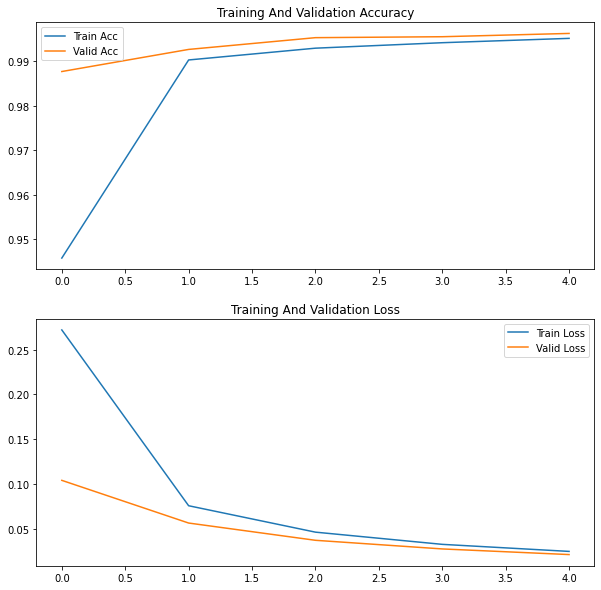

In [79]:
#plot
fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].plot(train_acc,label="Train Acc")
ax[0].plot(valid_acc,label="Valid Acc")
ax[0].title.set_text("Training And Validation Accuracy")
ax[0].legend(loc='best')

ax[1].plot(train_loss,label="Train Loss")
ax[1].plot(valid_loss,label="Valid Loss")
ax[1].title.set_text("Training And Validation Loss")
ax[1].legend(loc='best')

plt.show()

### Evaluate on Test Set

In [80]:
#evaluate test set
acc_xception, loss_xception = model_xception.evaluate(test_ds)

73/73 [==============================] - 2s 29ms/step - loss: 0.0217 - accuracy: 0.9940


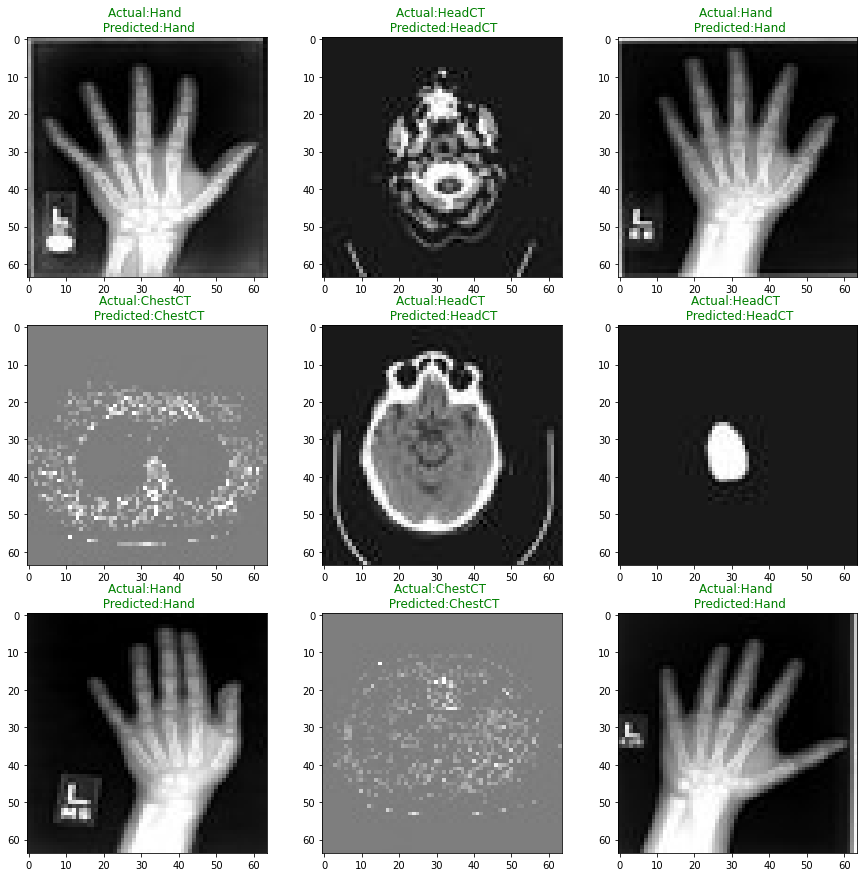

In [81]:
#visualize some results
image_batch, label_batch = next(iter(test_ds))
predictions = model_xception.predict(image_batch)
predictions = np.argmax(predictions,axis=1)

fig, ax = plt.subplots(3,3,figsize=(15,15))

for index, a in enumerate(fig.axes):
  a.imshow(np.array(image_batch[index],dtype=np.uint8))
  a.title.set_text(f"Actual:{class_names[label_batch[index]]} \n Predicted:{class_names[predictions[index]]}")
  if predictions[index] == label_batch[index]:
    a.title.set_color("green")
  else:
    a.title.set_color("red")

plt.show()

## Mobile Net V2

### Download base Model

In [82]:
base_model_mobilenetv2 = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top=False,
                                                                        weights="imagenet",
                                                                        input_shape=None)

### Get Model's Preprocessing Function

In [83]:
mobilenetv2_preprocessing = tf.keras.applications.mobilenet_v2.preprocess_input

### Visualize ouputs of Model's Preprocessing Function

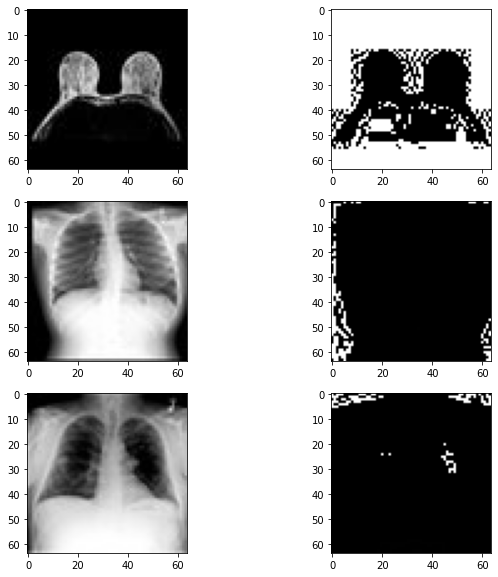

In [84]:
image_batch, label_batch = next(iter(train_ds))
preprocessed_image_batch = mobilenetv2_preprocessing(image_batch)

fig, ax = plt.subplots(3,2,figsize=(10,10))

ax[0,0].imshow(np.array(image_batch[0],dtype=np.uint8))
ax[0,1].imshow(np.array(preprocessed_image_batch[0],dtype=np.uint8))

ax[1,0].imshow(np.array(image_batch[1],dtype=np.uint8))
ax[1,1].imshow(np.array(preprocessed_image_batch[1],dtype=np.uint8))

ax[2,0].imshow(np.array(image_batch[2],dtype=np.uint8))
ax[2,1].imshow(np.array(preprocessed_image_batch[2],dtype=np.uint8))

plt.show()

### Freeze model for transfer learning

In [85]:
base_model_mobilenetv2.trainable = False

In [86]:
base_model_xception.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_7[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

### See output shape of base layer

In [87]:
inputs = tf.keras.Input(shape=(IMAGE_SHAPE))
x = mobilenetv2_preprocessing(inputs)
outputs = base_model_mobilenetv2(x)

model_mobilenetv2 = tf.keras.Model(inputs,outputs)

In [88]:
predictions = model_mobilenetv2(image_batch)

In [89]:
predictions.shape

TensorShape([32, 2, 2, 1280])

The outputs shape of base layer is 2x2x1280. In order generate predictions from 2x2 spatial feature, a global pooling layer must be used.

### Create a transfer learning model

In [90]:
inputs = tf.keras.Input(shape=(IMAGE_SHAPE))
x = mobilenetv2_preprocessing(inputs)
x = base_model_mobilenetv2(x)
x = tf.keras.layers.GlobalAveragePooling2D() (x)
outputs = tf.keras.layers.Dense(units=len(class_names),activation='softmax')(x)

model_mobilenetv2 = tf.keras.Model(inputs,outputs)

In [91]:
base_learning_rate = 0.0001
model_mobilenetv2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                          metrics=['accuracy'])


In [92]:
model_mobilenetv2.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
tf.math.truediv_4 (TFOpLambd (None, 64, 64, 3)         0         
_________________________________________________________________
tf.math.subtract_4 (TFOpLamb (None, 64, 64, 3)         0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_____________________________________________

In [93]:
#initial accuray and loss
acc0_mobilenet, loss0_mobilenet = model_mobilenetv2.evaluate(valid_ds)

296/296 [==============================] - 6s 15ms/step - loss: 2.7403 - accuracy: 0.1724


### Train Model

In [94]:
history_mobilenetv2 = model_mobilenetv2.fit(train_ds,
                                            epochs=5,
                                            validation_data = valid_ds)

Epoch 1/5
1474/1474 [==============================] - 28s 17ms/step - loss: 0.3045 - accuracy: 0.9208 - val_loss: 0.0718 - val_accuracy: 0.9866
Epoch 2/5
1474/1474 [==============================] - 25s 17ms/step - loss: 0.0439 - accuracy: 0.9944 - val_loss: 0.0319 - val_accuracy: 0.9947
Epoch 3/5
1474/1474 [==============================] - 25s 17ms/step - loss: 0.0211 - accuracy: 0.9980 - val_loss: 0.0184 - val_accuracy: 0.9970
Epoch 4/5
1474/1474 [==============================] - 26s 17ms/step - loss: 0.0122 - accuracy: 0.9987 - val_loss: 0.0120 - val_accuracy: 0.9985
Epoch 5/5
1474/1474 [==============================] - 25s 17ms/step - loss: 0.0078 - accuracy: 0.9993 - val_loss: 0.0084 - val_accuracy: 0.9988


### Plot learning curves

In [95]:
#get training accuracy and loss from history
train_acc = history_mobilenetv2.history['accuracy']
train_loss = history_mobilenetv2.history['loss']

#get validation accuracy and loss from history
valid_acc = history_mobilenetv2.history['val_accuracy']
valid_loss = history_mobilenetv2.history['val_loss']

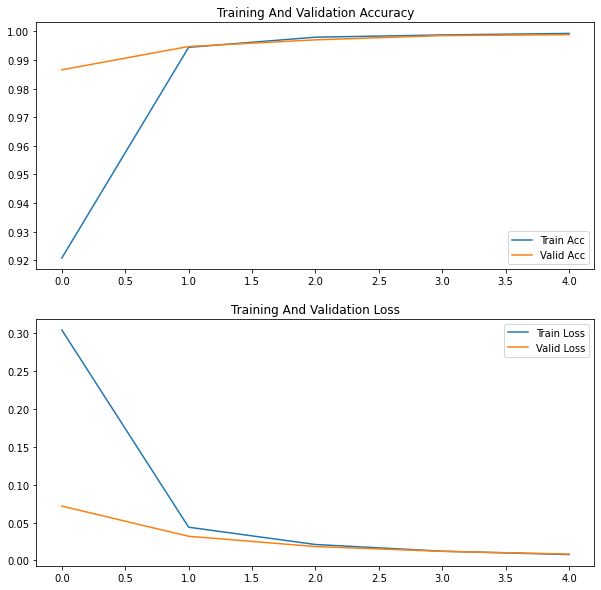

In [96]:
#plot
fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].plot(train_acc,label="Train Acc")
ax[0].plot(valid_acc,label="Valid Acc")
ax[0].title.set_text("Training And Validation Accuracy")
ax[0].legend(loc='best')

ax[1].plot(train_loss,label="Train Loss")
ax[1].plot(valid_loss,label="Valid Loss")
ax[1].title.set_text("Training And Validation Loss")
ax[1].legend(loc='best')

plt.show()

### Evaluate on Test Set

In [97]:
#evaluate test set
acc_mobilenetv2, loss_mobilenetv2 = model_mobilenetv2.evaluate(test_ds)

73/73 [==============================] - 1s 15ms/step - loss: 0.0090 - accuracy: 0.9970


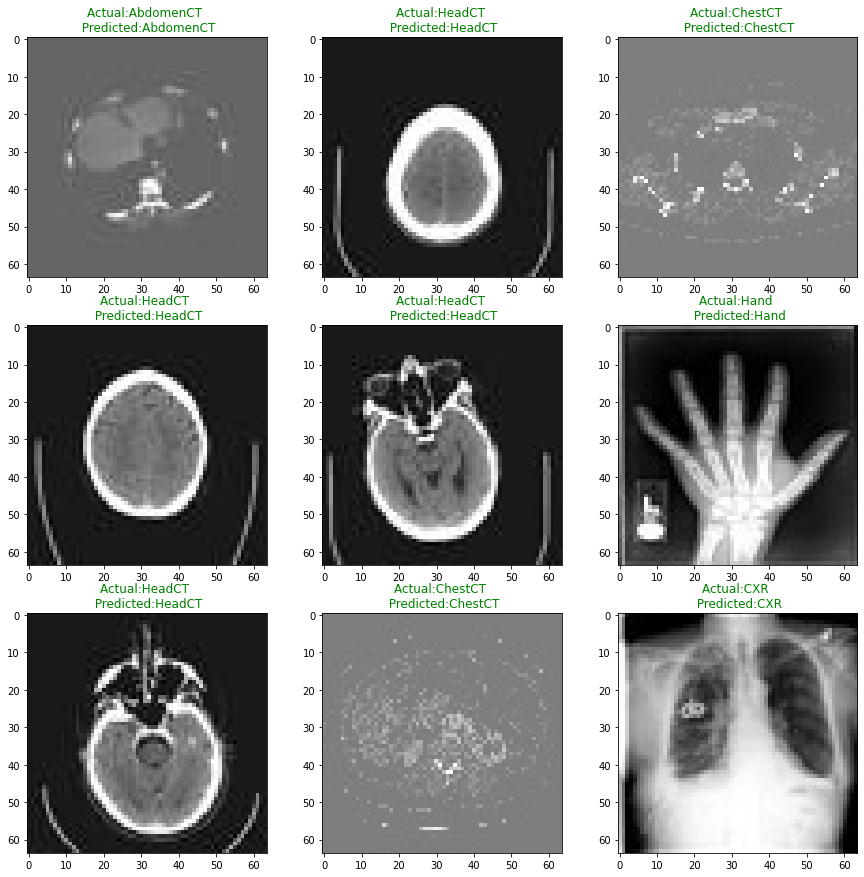

In [98]:
#visualize some results
image_batch, label_batch = next(iter(test_ds))
predictions = model_mobilenetv2.predict(image_batch)
predictions = np.argmax(predictions,axis=1)

fig, ax = plt.subplots(3,3,figsize=(15,15))

for index, a in enumerate(fig.axes):
  a.imshow(np.array(image_batch[index],dtype=np.uint8))
  a.title.set_text(f"Actual:{class_names[label_batch[index]]} \n Predicted:{class_names[predictions[index]]}")
  if predictions[index] == label_batch[index]:
    a.title.set_color("green")
  else:
    a.title.set_color("red")

plt.show()

## EfficientNet B7

### Download Base Model

In [99]:
base_efficientb7 = tf.keras.applications.efficientnet.EfficientNetB7(include_top=False,
                                                                     weights='imagenet',
                                                                     input_shape=None)

### Get Model's Preprocessing Function

In [100]:
efficientb7_preprocessing = tf.keras.applications.efficientnet.preprocess_input

### Visualize outputs of Model's Perprocessing Function

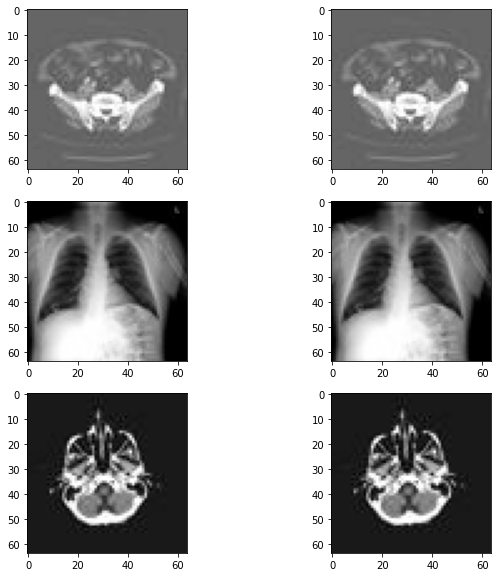

In [101]:
image_batch, label_batch = next(iter(train_ds))
preprocessed_image_batch = efficientb7_preprocessing(image_batch)

fig, ax = plt.subplots(3,2,figsize=(10,10))

ax[0,0].imshow(np.array(image_batch[0],dtype=np.uint8))
ax[0,1].imshow(np.array(preprocessed_image_batch[0],dtype=np.uint8))

ax[1,0].imshow(np.array(image_batch[1],dtype=np.uint8))
ax[1,1].imshow(np.array(preprocessed_image_batch[1],dtype=np.uint8))

ax[2,0].imshow(np.array(image_batch[2],dtype=np.uint8))
ax[2,1].imshow(np.array(preprocessed_image_batch[2],dtype=np.uint8))

plt.show()

### Freeze model for tranfer learning

In [102]:
base_efficientb7.trainable = False

In [103]:
base_efficientb7.summary()

Model: "efficientnetb7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_14[0][0]                   
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

### See output shape of base layer

In [104]:
inputs = tf.keras.Input(shape=(IMAGE_SHAPE))
x = efficientb7_preprocessing(inputs)
outputs = base_efficientb7(x)

model = tf.keras.Model(inputs,outputs)

In [105]:
predictions = model(image_batch)

In [106]:
predictions.shape

TensorShape([32, 2, 2, 2560])

As shown above the base output of efficentnet is 2x2x2560.In order to generate predictions out of 2x2 spatial features, a global pooling layer must be used.

### Create a transfer learning model

In [107]:
inputs = tf.keras.Input(shape=(IMAGE_SHAPE))
x = efficientb7_preprocessing(inputs)
x = base_model_mobilenetv2(x)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(units=len(class_names),activation='softmax')(x)

model_efficientnetb7 = tf.keras.Model(inputs,outputs)

In [108]:
model_efficientnetb7.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                             metrics=['accuracy'])

In [109]:
model_efficientnetb7.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 64, 64, 3)]       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d_4 ( (None, 1280)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 7686      
Total params: 2,265,670
Trainable params: 7,686
Non-trainable params: 2,257,984
_________________________________________________________________


In [110]:
#initial accuray and loss
acc0_efficientnetb7, loss0_efficientnetb7 = model_efficientnetb7.evaluate(valid_ds)

296/296 [==============================] - 6s 14ms/step - loss: 2.2241 - accuracy: 0.1726


### Train Model

In [111]:
history_efficientnetb7 = model_efficientnetb7.fit(train_ds,
                                                  epochs=5,
                                                  validation_data=valid_ds)

Epoch 1/5
1474/1474 [==============================] - 28s 17ms/step - loss: 0.3387 - accuracy: 0.9132 - val_loss: 0.0976 - val_accuracy: 0.9829
Epoch 2/5
1474/1474 [==============================] - 25s 17ms/step - loss: 0.0713 - accuracy: 0.9848 - val_loss: 0.0514 - val_accuracy: 0.9886
Epoch 3/5
1474/1474 [==============================] - 27s 18ms/step - loss: 0.0436 - accuracy: 0.9900 - val_loss: 0.0347 - val_accuracy: 0.9916
Epoch 4/5
1474/1474 [==============================] - 25s 17ms/step - loss: 0.0313 - accuracy: 0.9923 - val_loss: 0.0259 - val_accuracy: 0.9941
Epoch 5/5
1474/1474 [==============================] - 25s 17ms/step - loss: 0.0245 - accuracy: 0.9940 - val_loss: 0.0210 - val_accuracy: 0.9945


### Plot learning curves

In [112]:
#get training accuracy and loss from history
train_acc = history_efficientnetb7.history['accuracy']
train_loss = history_efficientnetb7.history['loss']

#get validation accuracy and loss from history
valid_acc = history_efficientnetb7.history['val_accuracy']
valid_loss = history_efficientnetb7.history['val_loss']

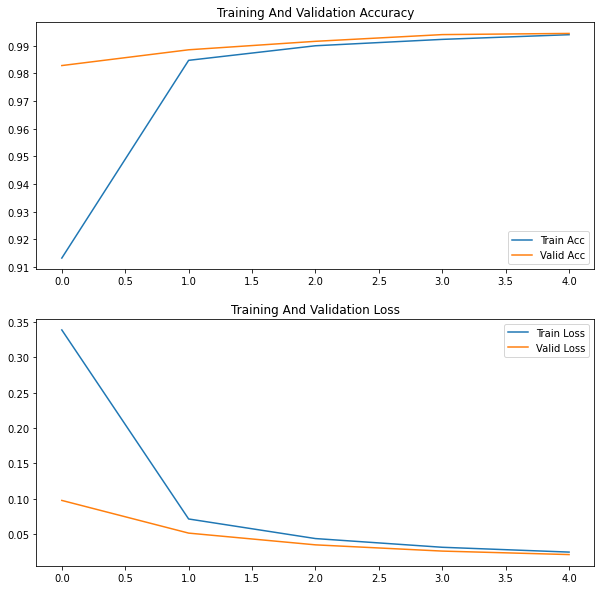

In [113]:
#plot
fig, ax = plt.subplots(2,1,figsize=(10,10))

ax[0].plot(train_acc,label="Train Acc")
ax[0].plot(valid_acc,label="Valid Acc")
ax[0].title.set_text("Training And Validation Accuracy")
ax[0].legend(loc='best')

ax[1].plot(train_loss,label="Train Loss")
ax[1].plot(valid_loss,label="Valid Loss")
ax[1].title.set_text("Training And Validation Loss")
ax[1].legend(loc='best')

plt.show()

### Evaluate on Test Set

In [114]:
#evaluate test set
acc_efficientnetb7, loss_efficientnetb7 = model_efficientnetb7.evaluate(test_ds)

73/73 [==============================] - 1s 15ms/step - loss: 0.0327 - accuracy: 0.9923


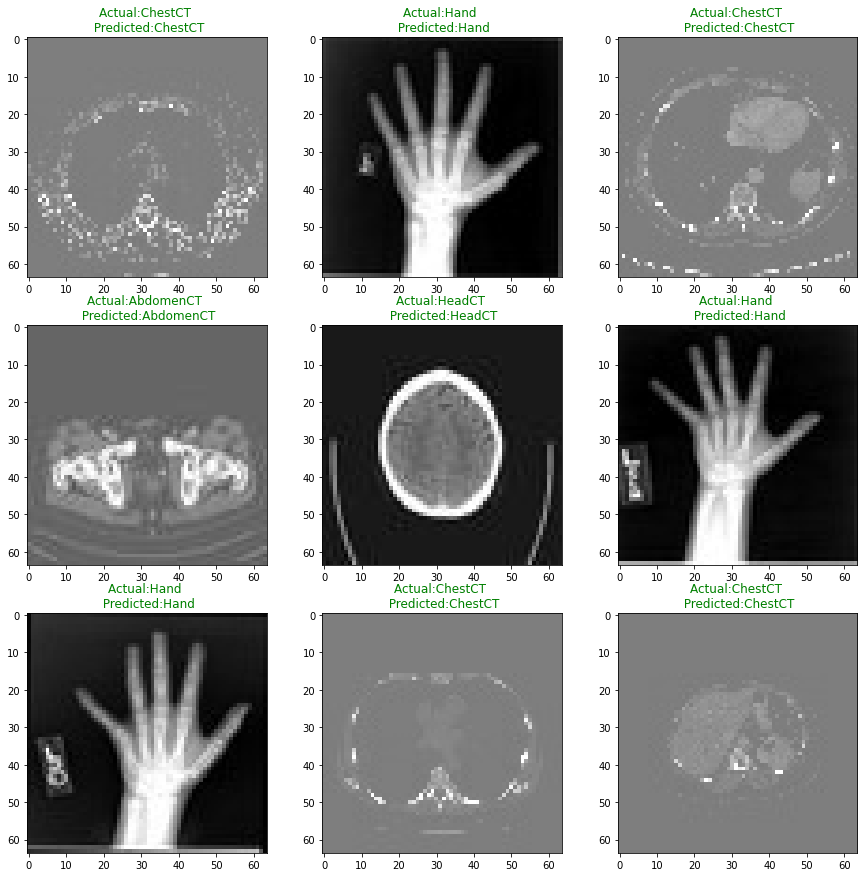

In [115]:
#visualize some results
image_batch, label_batch = next(iter(test_ds))
predictions = model_efficientnetb7.predict(image_batch)
predictions = np.argmax(predictions,axis=1)

fig, ax = plt.subplots(3,3,figsize=(15,15))

for index, a in enumerate(fig.axes):
  a.imshow(np.array(image_batch[index],dtype=np.uint8))
  a.title.set_text(f"Actual:{class_names[label_batch[index]]} \n Predicted:{class_names[predictions[index]]}")
  if predictions[index] == label_batch[index]:
    a.title.set_color("green")
  else:
    a.title.set_color("red")

plt.show()

## Compare Learning Curves of all models

In [116]:
#history_vgg19
#history_resnet50v2
#history_xception
#history_mobilenetv2
#history_efficientnetb7

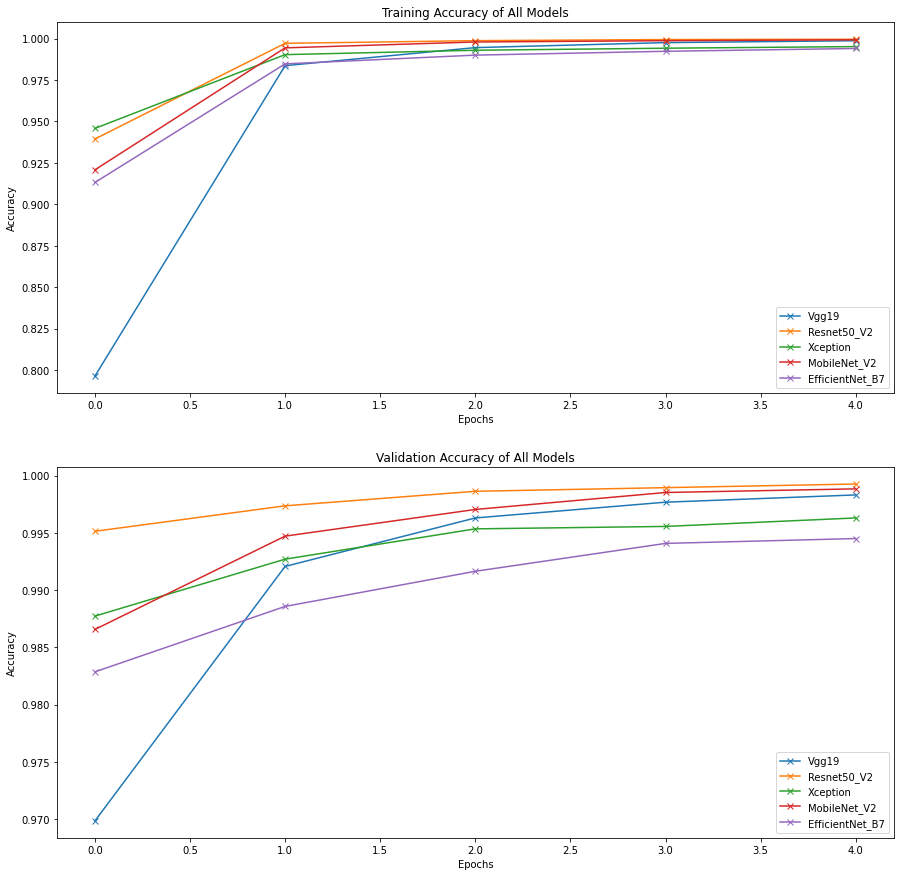

In [131]:
#plot Trainning Accuracy, Validation Accuray for all curves
fig, ax = plt.subplots(2,1,figsize=(15,15))

ax[0].plot(history_vgg19.history['accuracy'],'x-',label="Vgg19")
ax[0].plot(history_resnet50v2.history['accuracy'],'x-',label="Resnet50_V2")
ax[0].plot(history_xception.history['accuracy'],'x-',label="Xception")
ax[0].plot(history_mobilenetv2.history['accuracy'],'x-',label="MobileNet_V2")
ax[0].plot(history_efficientnetb7.history['accuracy'],'x-',label="EfficientNet_B7")
ax[0].title.set_text("Training Accuracy of All Models")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")
ax[0].legend(loc='best')

ax[1].plot(history_vgg19.history['val_accuracy'],'x-',label="Vgg19")
ax[1].plot(history_resnet50v2.history['val_accuracy'],'x-',label="Resnet50_V2")
ax[1].plot(history_xception.history['val_accuracy'],'x-',label="Xception")
ax[1].plot(history_mobilenetv2.history['val_accuracy'],'x-',label="MobileNet_V2")
ax[1].plot(history_efficientnetb7.history['val_accuracy'],'x-',label="EfficientNet_B7")
ax[1].title.set_text("Validation Accuracy of All Models")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend(loc='best')

plt.show()

In [132]:
fig.savefig('Accuracy_Comparision.jpg')

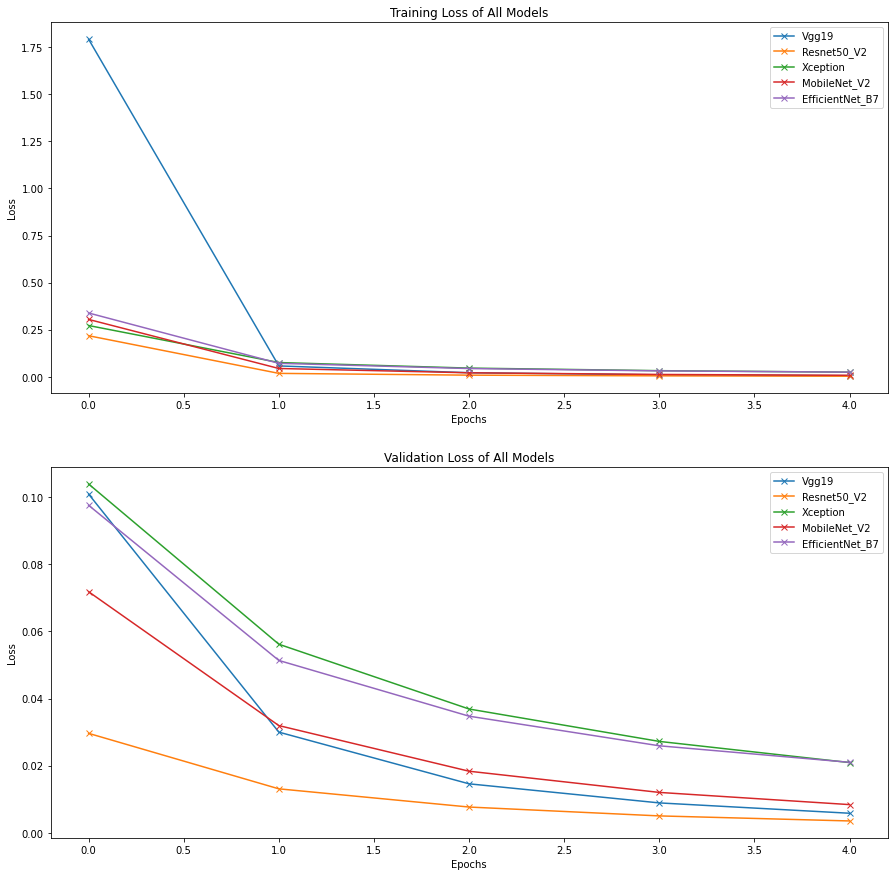

In [133]:
#plot Trainning Accuracy, Validation Losses for all curves

fig, ax = plt.subplots(2,1,figsize=(15,15))

ax[0].plot(history_vgg19.history['loss'],'x-',label="Vgg19")
ax[0].plot(history_resnet50v2.history['loss'],'x-',label="Resnet50_V2")
ax[0].plot(history_xception.history['loss'],'x-',label="Xception")
ax[0].plot(history_mobilenetv2.history['loss'],'x-',label="MobileNet_V2")
ax[0].plot(history_efficientnetb7.history['loss'],'x-',label="EfficientNet_B7")
ax[0].title.set_text("Training Loss of All Models")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend(loc='best')

ax[1].plot(history_vgg19.history['val_loss'],'x-',label="Vgg19")
ax[1].plot(history_resnet50v2.history['val_loss'],'x-',label="Resnet50_V2")
ax[1].plot(history_xception.history['val_loss'],'x-',label="Xception")
ax[1].plot(history_mobilenetv2.history['val_loss'],'x-',label="MobileNet_V2")
ax[1].plot(history_efficientnetb7.history['val_loss'],'x-',label="EfficientNet_B7")
ax[1].title.set_text("Validation Loss of All Models")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
ax[1].legend(loc='best')

plt.show()

In [134]:
fig.savefig('Loss_Comparision.jpg')

## Compare on Test Set


| Model Name | Loss | Accuracy |
| :---       | :---     | :--- |
|Vgg-19 | 0.0041 | 0.9991 |
|Resnet_V2 | 0.0018 | 1.0000 |
|Xception | 0.0220 | 0.9944 |
|MobileNet_V2 | 0.0071 | 0.9987 |
| EfficentNet_B7 | 0.0336 | 0.9932 |